In [1]:
from fastai import *
from fastai.text import *
from fastai.datasets import *
from pathlib import Path
import html
import fastai

In [2]:
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.0.1.post2


In [3]:
PATH=Path('/home/dell/Code/fastai_examples/pubmed-rct-200k/')
PATH.mkdir(exist_ok=True)
DATA_PATH=Path('/home/dell/Code/fastai_examples/data/pubmed-rct-200k')
DATA_PATH.mkdir(exist_ok=True)

In [4]:
#path = untar_data("http://files.fast.ai/data/examples/imdb_sample.tgz",dest=DATA_PATH)
#path = Path('/home/dell/Code/fastai_examples/data/imdb_sample/')

In [5]:
testData = pd.read_csv(DATA_PATH/'test.txt', sep="\t", header=None, comment='#')
testData.columns = ["label", "text"]
testData.dropna(inplace=True)
testData.head()

,label,text
0,BACKGROUND,Many pathogenic processes and diseases are the...
1,BACKGROUND,It was recently demonstrated that supraphysiol...
2,BACKGROUND,"In the present study , we examined the associa..."
3,BACKGROUND,"In addition , we compared plasma levels of MAp..."
4,METHODS,A total of 192 MI patients and 140 control per...


In [6]:
trainData = pd.read_csv(DATA_PATH/'train.txt', sep="\t", header=None, comment='#')
trainData.columns = ["label", "text"]
trainData.dropna(inplace=True)
trainData.head()

,label,text
0,BACKGROUND,The emergence of HIV as a chronic condition me...
1,BACKGROUND,This paper describes the design and evaluation...
2,METHODS,This study is designed as a randomised control...
3,METHODS,The intervention group will participate in the...
4,METHODS,The program is based on self-efficacy theory a...


In [7]:
#df = pd.read_csv(path/'texts.csv')
#df.head()

In [46]:
dataProcess = False
modelTrain = False

In [9]:
if dataProcess:
  # Language model data
  data_lm = TextLMDataBunch.from_df(PATH,train_df=trainData, valid_df = testData)
  data_lm.save(PATH/'data_lm_export.pkl')
  # Classifier model data
  data_clas = TextClasDataBunch.from_df(PATH, train_df=trainData,valid_df = testData , \
                                        vocab=data_lm.train_ds.vocab, bs=32)
  data_clas.save(PATH/'data_clas_export.pkl')
else:
  data_lm = load_data(PATH, fname='data_lm_export.pkl')
  data_clas = load_data(PATH, fname='data_clas_export.pkl', bs=16)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


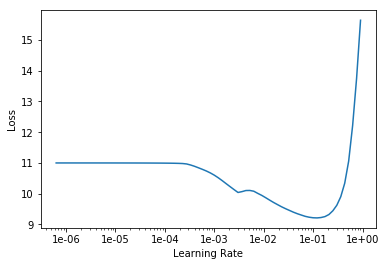

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn.lr_find()
learn.recorder.plot()

In [143]:
preTrainedWt103Path = Path('/home/dell/Code/fastai_examples/data/models/wt103')
# ! wget -nH -r -np -P {preTrainedWt103Path} http://files.fast.ai/models/wt103/ 

In [47]:
if modelTrain:
    learn.load_pretrained(wgts_fname = preTrainedWt103Path/'fwd_wt103.h5', itos_fname = preTrainedWt103Path/'itos_wt103.pkl', strict=False )
    #learn.load_encoder(name=preTrainedWt103Path/'fwd_wt103_enc.h5')
    # all layers now trainable
    #learn.unfreeze()
    # optionally, separate LR and WD for each group
    #learn.fit_one_cycle(10, max_lr=(1e-5, 1e-4, 1e-3, 1e-2), wd=(1e-4,1e-4,1e-4,1e-1))
    learn.fit_one_cycle(1, 1e-2)
    #learn.freeze()
    #pathModel = learn.save(PATH/"trained_model_unfreeze")
    #pathModel = learn.save(PATH/"trained_model")
else:
    learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, pretrained=False)
    learn.load(PATH/"trained_model")

We can we visualize  text classifier as three different part, 1 and 2 is backbone and 3 is head.

1- Embedding layer (Convert integer of words to meaningful vectors)
2- 3 Layer LSTM network (Learned from wikitext and language-model)
3- Finallinear layer  network for Prediction

In [15]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60003, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60003, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60003, bias=True)
    (output_dp): RNNDropout()
  )
)

In [50]:
learn.predict("actin is an important protein ", n_words=50)

'actin is an important protein  in cancer survivors . xxbos The mean target btfc for Latanoprost - Timolol was 7 mmhg . xxbos Soc and WBC count of predefined thresholds were shifted . xxbos The insulin safety and early - medoxomil g - CSF use in the presence'

In [17]:
x_inp = ["i like apples",
         "i want to buy some apples",
         "where is your cell phone",
        "buy me some apples"]

In [18]:
x_inp2 = ["Apple dog Apple dog Apple dog Apple Apple Apple Apple Apple Apple",
         "phone dog phone dog phone dog phone phone dog phone dog phone dog",
         "cat tree cat tree cat tree cat tree cat tree cat tree tree cat cat tree cat"]

In [19]:
x_inp3 = ["cancer",
         "finger",
          "actin",
         "tumor",
         "hand",
         "kras",
         "filament"]

In [20]:
x_inp4 = ["HLA-F",
          #skeleton
         "TFAP2A",
          #immune         
         "KIR2DL4",
          #skeleton
         "CHST11",
           #immune 
         "ARRB2", 
          #skeleton
         "SIX2",
          #immune
         "LGALS9",
          #skeleton
         "TULP3",
          #immune 
         "SERPINB9",
          #skeleton
         "SMAD3",
          #immune 
         "MICA",
          #skeleton
         "GNAS"]

In [21]:
x_inp5 = [
          #skeleton
         "TFAP2A",
          #skeleton
         "GNAS",
          #skeleton
         "CHST11",
          #skeleton
         "SMAD3",
          #skeleton
         "SIX2",
          #skeleton
         "TULP3",
          #immune 
          "HLA-F",
         #immune 
         "ARRB2", 
          #immune
         "LGALS9",
          #immune 
         "SERPINB9",
          #immune 
         "MICA",
          #immune         
         "KIR2DL4"
]

In [22]:
x_inp6 = ["there is no comparison here. you are comparing apples to oranges",
         "i compared the prices of apples and oranges at walmart and kroger stores",
         "i don't see anything common between these two categories."]

Elemanların sırası değişince cos_sim de değişiyor !!!

In [23]:
x_inp7 = ["king",
         "woman",
          "man",
         "queen"
         ]

In [24]:
inputs = x_inp7

In [25]:
import multiprocessing
n_cpu = multiprocessing.cpu_count()

In [26]:
tok = Tokenizer().process_all(partition_by_cores(inputs,n_cpu-1))
tok

[['[', "'", 'king', "'", ']'],
 ['[', "'", 'woman', "'", ']'],
 ['[', "'", 'man', "'", ']'],
 ['[', "'", 'queen', "'", ']']]

In [27]:
import re 

filteredTokens = []
for tokenizedWord in tok:
    filteredToken = [token for token in tokenizedWord if not re.search('xx',token)]
    filteredTokens.append(filteredToken)
filteredTokens

[['[', "'", 'king', "'", ']'],
 ['[', "'", 'woman', "'", ']'],
 ['[', "'", 'man', "'", ']'],
 ['[', "'", 'queen', "'", ']']]

In [28]:
X = [[data_lm.vocab.stoi[o1] for o1 in o ] for o in filteredTokens]; X 

[[95, 265, 10431, 265, 97],
 [95, 265, 4586, 265, 97],
 [95, 265, 6805, 265, 97],
 [95, 265, 22585, 265, 97]]

In [29]:
X = [element for element in X if element[2] != 0 ]; X

[[95, 265, 10431, 265, 97],
 [95, 265, 4586, 265, 97],
 [95, 265, 6805, 265, 97],
 [95, 265, 22585, 265, 97]]

In [30]:
m = learn.model

In [31]:
X[0][2:-2]

[10431]

In [32]:
#inputs = []
embeddings = []    
for sentence in X:
    #resizeLength = len(x_inp4)
    sentenceTrimmed= sentence[2:-2]
    resizeLength = len(sentenceTrimmed)
    inputSentence = tensor(sentenceTrimmed).resize_(resizeLength,1)
    # sentence encoding 400 dims. -1 is the last element that's supposed to have the final encoded state
    tmpEmbded = m[0](inputSentence.cuda())
    embeddings.append(tmpEmbded[0][2][0][-1])

In [134]:
def cos_sim(v1,v2):
    return F.cosine_similarity(v1.unsqueeze(0),v2.unsqueeze(0))#.mean()

In [138]:
vv1 = tensor(list([float(i) for i in range(84)])).unsqueeze(0)
vv2 = tensor(list([float(i) for i in range(84)])).unsqueeze(0)

F.cosine_similarity(vv1,vv2).item()

1.0000001192092896

In [54]:
inputs

['king', 'woman', 'man', 'queen']

In [142]:
i=0
for embedding1 in embeddings:
    j=0
    for embedding2 in embeddings:
        #corr = data_lm.vocab.itos[X[i][2]] + " with " + data_lm.vocab.itos[X[j][2]]
        corr = inputs[i] + " with " + inputs[j]
        print(corr)
        print(cos_sim(embedding1,embedding2).item())
        j+=1
    i+=1

king with king
1.0000001192092896
king with woman
0.7271730303764343
king with man
0.5179768204689026
king with queen
0.5232836008071899
woman with king
0.7271730303764343
woman with woman
0.9999999403953552
woman with man
0.848972737789154
woman with queen
0.7131264805793762
man with king
0.5179768204689026
man with woman
0.848972737789154
man with man
1.0
man with queen
0.5135998129844666
queen with king
0.5232836008071899
queen with woman
0.7131264805793762
queen with man
0.5135998129844666
queen with queen
0.9999999403953552


king with king
1.0
king with queen
0.8165188431739807
king with man
0.7117255330085754
king with woman
0.6742797493934631
queen with king
0.8165188431739807
queen with queen
0.9999999403953552
queen with man
0.8113273978233337
queen with woman
0.7203792929649353
man with king
0.7117255330085754
man with queen
0.8113273978233337
man with man
1.0000001192092896
man with woman
0.9140985608100891
woman with king
0.6742797493934631
woman with queen
0.7203792929649353
woman with man
0.9140985608100891
woman with woman
0.9999999403953552